### A notebook for data exploration and function testing for predict sales web app 

### Contents:
1. Data exploration
2. Feature engineering and train,test and predict split
3. Creating a base estimator to compare with
4. Creating and testing linear model
5. Creating and testing XGBoost model 
6. Tuning parameters and getting feature importance for the best model 
7. Testing on unseen shops
8. Conclusions

## 1. Data exploration

### A long cell with functions from app/process_data.py - you can ignore it and scroll past 

In [295]:
# import libraries
import sys
import pandas as pd
import datetime
import math
import numpy as np


def preprocess_data(sales_filepath, items_filepath, use_shop_ids=[38,42,35,23,32,24,4,5,12,29]):
    '''
        preprocess_data() - function that transforms initial training data CSV files into a dataframe 
                            in a format that can be then processed and used in training pipeline
        Input:
            sales_filepath - (str) path to training sales data 
            items_filepath - (str) path to training data on items (names, categories)
            use_shop_ids - (list) a subset of int shop ids from 'sales_filepath' CSV file to use during training to reduce training time
        Output:
            data - (pd.DataFrame) a Pandas dataframe with sales data

    '''
    sales_train = pd.read_csv(sales_filepath)
    items = pd.read_csv(items_filepath)
    data = sales_train[sales_train['shop_id'].isin(use_shop_ids) ].drop(columns=['date_block_num']).reset_index(drop=True)
    data = pd.merge(data, items, on=['item_id'], how='left')    

    return data

def check_data_correctnes(data):
    '''
        check_data_correctnes() - function that checks correctness of a dataframe format and data, and assigns a shop_id if none is given
                                  in case of a single shop in the data
        Input:
            data - (pd.DataFrame) a Pandas dataframe with sales data
            Needed columns are: date, shop_id, item_id, item_price, item_cnt_day, item_name, item_category_id
        Output:
            data - (pd.DataFrame) a Pandas dataframe with sales data with necessary changes if needed (add shop_id if empty),
            OR
            raises an exception to let the web app know that format is incorrect 
    '''
    data['shop_id'] = data['shop_id'].fillna('shop1')
    return data

def clean_and_aggreagate(data):
    '''
        clean_and_aggreagate() - function that cleanes, aggregates and sorts a Pandas dataframe for training or predicting sales
        Input:
            data - (pd.DataFrame) a Pandas dataframe with sales data
        Output:
            data_monthly - (pd.DataFrame) a cleaned and aggregated sorted dataframe
    '''

    # delete data with negative item counts or prices
    data = data[data['item_cnt_day']>0]
    data = data[data['item_price']>0]
    # clean from any null values
    data = data.dropna()
    
    # convert date from string to datetime format
    data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

    # Add month and year and aggregate data
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

    # making sure we are getting only needed columns
    keep_columns_agg = ['shop_id', 'item_id', 'item_price', 'item_cnt_day', 'month', 'year', 'item_category_id']
    
    # aggregate data monthly and by shops and items 
    data_monthly = data[keep_columns_agg].groupby(['year','month', 'shop_id', 'item_category_id', 'item_id'], as_index=False).agg(
        {'item_price':'mean', 
        'item_cnt_day':['sum', 'mean'] })

    # make multilevel index flat
    data_monthly.columns = data_monthly.columns.map(''.join)

    # rename columns
    data_monthly = data_monthly.rename(columns={
        'item_pricemean': 'item_price_avg', 
        'item_cnt_daysum':'item_cnt_month',
        'item_cnt_daymean':'item_cnt_day_mean'})
    
    # sort the dataframe for future analysis
    data_monthly = data_monthly.sort_values(by=['year', 'month', 'shop_id', 'item_id']).reset_index(drop=True)

    return data_monthly

def add_empty_rows(data_monthly):
    '''
        add_empty_rows() - function that extends a dataframe of aggregated sales with skipped rows
                           so that the dataframe has explicit data on zero sales (sets 'item_cnt_month' to zero) 
                           instead of not mentioning an item for a particular month in a particular shop
        Input:
            data_monthly - (pd.DataFrame) sorted Pandas dataframe with aggregated sales data
        Output:
            data_monthly_ext - (pd.DataFrame) extended dataframe with explicit 0 rows
    '''
    item_ids = data_monthly['item_id'].unique()
    shop_ids = data_monthly['shop_id'].unique()

    start_date_year = int(data_monthly.iloc[0,:]['year'])
    start_date_month = int(data_monthly.iloc[0,:]['month'])
    end_date_year = int(data_monthly.iloc[-1,:]['year'])
    end_date_month = int(data_monthly.iloc[-1,:]['month'])

    # --- calculate total number of months in the period of historical data
    number_of_months = (end_date_year - start_date_year) * 12 + (end_date_month - start_date_month) + 1

    # will have data on all possible combinations of sales records
    # for given shops, items and given time period 
    zero_rows = []
    cur_month = start_date_month
    cur_year = start_date_year

    for i in range(number_of_months):
        for shop in shop_ids:
            for item in item_ids:
                # adding a row - transaction for certain shop, year, month and item that will be zeroes initially
                # and then joined with main data so that main data has explicit zeros as transactions
                row = [cur_year, cur_month, shop, item]
                zero_rows.append(row)
        
        # create a correction coeeficient for the case of December, 12th month, so that we het 12 and not 0
        add_12_if_receive_0 = (12 - 12*math.ceil((cur_month+1)%12 / 12))
        # increase month by 1, make sure it will be in [1,12] range
        cur_month = (cur_month+1)%12 + add_12_if_receive_0
        
        # increase year if we arrived to the 1st month, January, after increasing month
        if cur_month == 1:
            cur_year += 1

    # create a df of zero rows    
    zero_rows = pd.DataFrame(zero_rows, columns=['year', 'month', 'shop_id', 'item_id'])

    # merge zero rows with the main data, data_monthly
    data_monthly_ext = pd.merge(zero_rows, data_monthly, on=['year','month', 'shop_id','item_id'], how='left')
    # fill missing records with 0s
    data_monthly_ext.fillna(0, inplace=True)
    # make sure the dataframe is sorted
    data_monthly_ext = data_monthly_ext.sort_values(by=['year', 'month', 'shop_id', 'item_id']).reset_index(drop=True)

    return data_monthly_ext

def add_global_features(data_monthly_ext):
    '''
        add_global_features() - function that adds features for training and predicting purposes.
                                I called features global becasue they can be applied to the whole data
                                before splitting into train and test without any data leakage in terms of forecasting
        Input:
            data_monthly_ext - (pd.DataFrame) a sorted by year and month Pandas dataframe with aggregated sales data
        Output:
            data_monthly_ext - (pd.DataFrame) initial dataframe with new features
    '''
    # --- add date_block to split data into train and test
    start_month = data_monthly_ext.iloc[0,:]['month']
    start_year = data_monthly_ext.iloc[0,:]['year']

    # order of the starting month - we will subtract it from other month to understand how many month we moved forward
    starting_month_agg = start_year*12 + start_month
    # create arrays of year and month to perform calculations on them using np.vectorize
    years = np.array(data_monthly_ext['year'])
    months = np.array(data_monthly_ext['month'])
    # for better performance create a vectorized function that computes block number (order of month from starting month)
    calculate_block_num = np.vectorize(lambda year, month: (year*12 + month)- starting_month_agg)
    # number of months since year 0 in starting date - this will be subtracted to understand how many months we have moved ahead from start
    data_monthly_ext['date_block_num'] = calculate_block_num(years, months)

    # Feature engineering
    # add rolling statistics

    # define size of a rolling window
    rolling_window_size = 3
    # --- Calculate rolling statistics

    def function_mean(column):
        return column.rolling(window=rolling_window_size, min_periods=1).mean()

    data_monthly_ext['item_cnt_roll_mean'] = data_monthly_ext.groupby(['shop_id','item_id'])['item_cnt_month'].apply(function_mean)
    
    # store average number of items sold per month for each item in a shop up to this point using pd.expanding function
    data_monthly_ext['shop_item_mean_past'] = data_monthly_ext.groupby(['shop_id', 'item_id'])[['item_cnt_month']].expanding().mean().values
    
    # store average number of items sold per month for each year up to this point using pd.expanding function
    data_monthly_ext['year_mean_past'] = data_monthly_ext.groupby(['year'])[['item_cnt_month']].expanding().mean().values
    
    # store average number of items sold per month for each month up to this point using pd.expanding function
    data_monthly_ext['month_mean_past'] = data_monthly_ext.groupby(['month'])[['item_cnt_month']].expanding().mean().values


    # let us calculate lags for the past 3 months
    number_lags = range(1,4)

    # --- generate shifted number of items sold from the past 1-3 months
    for lag in number_lags:
        feature_name = 'item_cnt_shifted{}'.format(lag)
        data_monthly_ext[feature_name] = data_monthly_ext.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
        # Fill the empty shifted features with 0
        data_monthly_ext[feature_name] = data_monthly_ext[feature_name].fillna(0)

    # generate trend which shows the change in item sales count
    # trend = current - (previous_1 + ... + previous_n)/n = n*current - previous_1 - ... - previous_n, in our case n=3
    # initially fill with current sales multiplied by number of times we will substract previous values to get average
    data_monthly_ext['item_trend'] = len(number_lags) * data_monthly_ext['item_cnt_month']
    # then subtract previous n values
    for lag in number_lags:
        feature_name = 'item_cnt_shifted{}'.format(lag)
        data_monthly_ext['item_trend'] -= data_monthly_ext[feature_name]
    # then divide by the number of times we have subtracted previous values to get average
    data_monthly_ext['item_trend'] /= len(number_lags) 

    return data_monthly_ext


def add_labels(data_monthly_ext):
    '''
        add_labels() - function that creates labels = a column of values we will predict = sales next month for an item in a shop
        Input:
            data_monthly_ext - (pd.DataFrame) a Pandas dataframe with aggregated sorted sales data
        Output:
            data_monthly_ext - (pd.DataFrame) dataframe with new column - 'itm_cnt_nxt_mnth', which is sales next month for an item in a shop
    '''
    data_monthly_ext['itm_cnt_nxt_mnth'] = data_monthly_ext.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(-1)
    return data_monthly_ext

def split_train_test_predict(data_monthly_ext):
    '''
        split_train_test_predict() - function that splits data into train, test and predict, where predict - is the last available month in the data,
                       and for which we will be generating prediction for the next, unknown to us month. Test will be used to see how good is the model.
                       Since we are dealing with timeseries, we cannot simply randomly split data. We also want to split exactly by month periods, so the standard 
                       split function will not work.
        Input:
            data_monthly - (pd.DataFrame) a Pandas dataframe with aggregated sales data
        Output:
            train_set - (pd.DataFrame) training data
            test_set - (pd.DataFrame) testing data to see how we performed
            predict_set - (pd.DataFrame) set of sales for the last month for which we will predict future sales for the next unseen month
    '''
    # calculate date_block_num for splitting
    num_months = data_monthly_ext['date_block_num'].max() + 1
    # starting from the 3rd month as we have rolling statistics with 3 month window (date_block_num starts with 0)
    train_low = 3 - 1
    # get approximately 70% of the data
    train_high = int(0.7 * num_months) - 1
    # testing data will have all the rest of the month up to a last one, which is used for predictiong as it does not have data on next month sales
    test_high = num_months - 1

    train_set = data_monthly_ext[(data_monthly_ext['date_block_num'] >= train_low) & (data_monthly_ext['date_block_num'] <= train_high )].copy()
    test_set = data_monthly_ext[(data_monthly_ext['date_block_num'] > train_high) & (data_monthly_ext['date_block_num'] < test_high )].copy()
    predict_set = data_monthly_ext[data_monthly_ext['date_block_num'] == test_high].copy()

    # in train and test get rid of the null values in target variable
    train_set = train_set.dropna(subset=['itm_cnt_nxt_mnth'])
    test_set = test_set.dropna(subset=['itm_cnt_nxt_mnth'])

    return train_set, test_set, predict_set



def add_set_features(train, test):
    '''
        add_set_features() - function for more feature engineering done on each train and test sets to avoid data leakage.
                            We will be calculating statistics based on the sales in the next month, so cannot use it on predict set as
                            it does not have information on the future sales. On test set we are setting values calculated based on train data
                            because we want to avoid data leakage and test data "knowing" about sales we want to predict.
        Input:
            train_set - (pd.DataFrame) training data
            test_set - (pd.DataFrame) testing data to see how we performed
        Output:
            train_set - (pd.DataFrame) training data with new features
            test_set - (pd.DataFrame) testing data with new features based on training data without data that can help forecast values on test,
                        only past values from train are added here
    '''
    # each new feature will be a statistics computed by grouping and aggregating next month sales by certain dimensions
    # we will generate that grouped statistics and then merge larger ungrouped train and test dataframes with it
    # computing on train data for both train and test as we don't want to give away any information to test set
    # as the calculations are done on future sale and since we are dealing with timeseries

    def generate_statistics(dataset, group_by_columns, new_column_names, agg_column='itm_cnt_nxt_mnth', agg_function_names=['mean']):
        '''
            generate_statistics() - helper internal function for generating statistics of a dataset using grouping and aggregation
            Input:
                dataset - (pd.DataFrame) data frame to calculate statistics on
                group_by_columns - (list of str) columns to group by
                new_column_names - (list of str) how to name new resulting columns
                agg_column - (str) on which column the calculation will be performed
                agg_function_names - (list of str) which aggregate functions to use on 'agg_column' after grouping

            Output:
                res - (pd.DataFrame) dataframe with 'new_column_names' columns - result of grouping and applying aggreagate functions
        '''
        res = dataset.groupby(group_by_columns).agg({agg_column: agg_function_names})
        res.columns = new_column_names
        res.reset_index(inplace=True)
        return res


    # --- Add mean statistic features to train and test sets.

    # Averages for each item across all shops, months and years
    item_means = generate_statistics(train, ['item_id'], ['item_mean_future'])
    train = pd.merge(train, item_means, on=['item_id'], how='left')
    test = pd.merge(test, item_means, on=['item_id'], how='left')

    # Averages for each item in each shop across all months and years
    shop_item_means = generate_statistics(train, ['shop_id', 'item_id'], ['shop_item_mean_future'])
    train = pd.merge(train, shop_item_means, on=['shop_id', 'item_id'], how='left')
    test = pd.merge(test, shop_item_means, on=['shop_id', 'item_id'], how='left')
    
    # Averages for each category across all shops, months and years
    category_means = generate_statistics(train, ['item_category_id'], ['category_mean_future'])
    train = pd.merge(train, category_means, on=['item_category_id'], how='left')
    test = pd.merge(test, category_means, on=['item_category_id'], how='left')
    
    # Averages for each month across all shops, years and items
    month_means = generate_statistics(train, ['month'], ['month_mean_future'])
    train = pd.merge(train, month_means, on=['month'], how='left')
    test = pd.merge(test, month_means, on=['month'], how='left')
    
    # Fill the empty features with 0
    train = train.fillna(0)
    test = test.fillna(0)

    return train, test


def split_data_labels(train_set, test_set, predict_set):
    '''
        split_data_labels() - function that splits sets into data (features) and labels to predict, 
            specifically train and test into X_train, Y_train, X_test, Y_test 
            and also creates X_predict for prediction in the same format as X_train and X_test.
            X_predict - is the last available month in the data, and for which we will be generating prediction for the next, unknown to us, month. 
            Test will be used to see how good is the model.
            Since we are dealing with timeseries, we cannot simply randomly split data. We also want to split exactly by month periods, so the standard 
            split function will not work.
        Input:
            train_set - (pd.DataFrame) training data
            test_set - (pd.DataFrame) testing data to see how we performed
            predict_set - (pd.DataFrame) set of sales for the last month for which we will predict future sales for the next unseen month
        Output:
            X_train - (pd.DataFrame) training features
            Y_train - (pd.DataFrame) training labels
            X_test - (pd.DataFrame) testing features
            Y_test - (pd.DataFrame) testing labels
            X_predict - (pd.DataFrame) features for predicting unknown data  
    '''
    # create train and test sets and labels. 
    X_train = train_set.drop(['itm_cnt_nxt_mnth'], axis=1)
    Y_train = train_set['itm_cnt_nxt_mnth'].astype(int)
    X_test = test_set.drop(['itm_cnt_nxt_mnth'], axis=1)
    Y_test = test_set['itm_cnt_nxt_mnth'].astype(int)
    
    # create X_predict to predct next unseen month
    history = pd.concat([train_set, test_set]).drop_duplicates(subset=['item_id'], keep='last')
    X_predict = pd.merge(predict_set, history, on=['item_id'], how='left', suffixes=['', '_'])
    X_predict.drop('itm_cnt_nxt_mnth', axis=1, inplace=True)
    X_predict = X_predict[X_train.columns]

    return X_train, Y_train, X_test, Y_test, X_predict
    

def return_processed_data(data):
    '''
        return_processed_data() - function that combines all of the ETL steps for ML training and predicting.
                                  Raises exception if datafile is not in needed format or has less than 6 month of data
        Input:
            data - (pd.DataFrame) dataframe with sales data.
                    Needed columns are: date, shop_id, item_id, item_price, item_cnt_day, item_name, item_category_id
        Output:
            X_train - (pd.DataFrame) training features
            Y_train - (pd.DataFrame) training labels
            X_test - (pd.DataFrame) testing features
            Y_test - (pd.DataFrame) testing labels
            X_predict - (pd.DataFrame) data set (features) for predicting unknown data
            extended_predict_set - (pd.DataFrame) data set for predicting data, like X_predict, but with all the original columns (like item_id and etc.) to return to a user later
    '''
    data = check_data_correctnes(data)
    data_monthly = clean_and_aggreagate(data)
    data_monthly_ext = add_empty_rows(data_monthly)
    data_monthly_ext = add_global_features(data_monthly_ext)
    data_monthly_ext = add_labels(data_monthly_ext)
    train_set, test_set, predict_set = split_train_test_predict(data_monthly_ext)
    train_set, test_set = add_set_features(train_set, test_set)
    X_train, Y_train, X_test, Y_test, X_predict = split_data_labels(train_set, test_set, predict_set)


    # --- select features that will be used for training, testing and predicting

    features = ['shop_item_mean_future', 'item_cnt_month', 'item_trend', 'month_mean_future', 'item_cnt_roll_mean', 'item_cnt_day_mean', 
                'month_mean_past', 'item_mean_future', 'category_mean_future', 'shop_item_mean_past', 'year_mean_past']
    # ---- Select subsets
    # First, save the data we will be predicting before we will select features for modelling from it - 'extended_predict_set'. 
    # This will allow us to return prediction in a clear format to the user
    extended_test_set = X_test
    extended_predict_set = X_predict
    # --- subset other Xs            
    X_train = X_train[features]
    X_test = X_test[features]
    X_predict = X_predict[features]

    return X_train, Y_train, X_test, Y_test, X_predict, extended_test_set, extended_predict_set

def create_prediction_df(extended_predict_set, Y_predict, columns = ['year', 'month', 'shop_id', 'item_id', 'item_category_id', 'item_price_avg']):
    '''
        create_prediction_df() - a function that combines predicted target data (sales amount) with the data itself (shops, items, categories) into one Pandas dataframe
        Input:
            extended_predict_set - (pd.dataframe) dataframe with data (year, month, shops, items, categories, etc.)
            Y_predict - (list or numpy array) dataframe with predicted sales count for the next month
            columns = columns of extended_predict_set to keep
        Output:
            result_df - resulting df with combined data
    '''    
    result_df = extended_predict_set[columns].copy()

    # get current month and year
    cur_month = extended_predict_set['month'].iloc[0]
    cur_year = extended_predict_set['year'].iloc[0]

    # increase current month by 1 to output prediction
    cur_month += 1
    # check that we are less than 12, set to 1 if 13. '%' alone won't work as there is case of 12 that gives 0
    if cur_month == 13:
        cur_month = 1
        # increae a year by one
        cur_year += 1

    result_df.loc[:,'year'] = cur_year
    result_df.loc[:,'month'] = cur_month

    # add predicted sales
    result_df.loc[:,'predicted_number_items_sold'] =  Y_predict

    return result_df

## Select shops to train on 

In [155]:
data = preprocess_data('data/sales_train.csv', 'data/items.csv', use_shop_ids=range(30))

In [156]:
data.shape

(1357300, 7)

In [157]:
data_agg = clean_and_aggreagate(data)

In [158]:
data_agg.head()

,year,month,shop_id,item_category_id,item_id,item_price_avg,item_cnt_month,item_cnt_day_mean
0,2013,1,0,40,32,221.0,6.0,1.5
1,2013,1,0,37,33,347.0,3.0,1.0
2,2013,1,0,40,35,247.0,1.0,1.0
3,2013,1,0,40,43,221.0,1.0,1.0
4,2013,1,0,57,51,128.5,2.0,1.0


In [159]:
data_agg.shape

(745173, 8)

In [160]:
data_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
year,745173.0,2013.778890,0.780940,2013.00,2013.0,2014.0,2014.0,2015.0
month,745173.0,6.090788,3.474579,1.00,3.0,6.0,9.0,12.0
shop_id,745173.0,17.838409,8.586221,0.00,10.0,19.0,25.0,29.0
item_category_id,745173.0,41.338618,16.496649,0.00,30.0,40.0,55.0,83.0
item_id,745173.0,10547.819149,6250.862902,18.00,4907.0,10300.0,15996.0,22169.0
item_price_avg,745173.0,821.537296,1608.297268,0.09,199.0,399.0,899.0,307980.0
item_cnt_month,745173.0,2.298121,8.805831,1.00,1.0,1.0,2.0,2253.0
item_cnt_day_mean,745173.0,1.085481,1.738946,1.00,1.0,1.0,1.0,1000.0


In [161]:
data_agg.tail()

,year,month,shop_id,item_category_id,item_id,item_price_avg,item_cnt_month,item_cnt_day_mean
745168,2015,10,28,37,22145,199.0,1.0,1.0
745169,2015,10,28,37,22154,299.0,1.0,1.0
745170,2015,10,28,40,22162,349.0,1.0,1.0
745171,2015,10,28,40,22163,169.0,1.0,1.0
745172,2015,10,28,49,22167,299.0,1.0,1.0


In [162]:
numb_transactions = data.shape[0]
print('Number of transactions is {}'.format(numb_transactions))

Number of transactions is 1357300


In [163]:
numb_shops = data_agg['shop_id'].nunique()
print('Number of shops is {}'.format(numb_shops))

Number of shops is 30


In [164]:
numb_categories = data_agg['item_category_id'].nunique()
print('Number of categories is {}'.format(numb_categories))

Number of categories is 73


In [165]:
numb_items = data_agg['item_id'].nunique()
print('Number of unique items is {}'.format(numb_items))

Number of unique items is 18712


### Explore trends and seasonality in the data 

## 2. Feature engineering  and train, test split

### Steps below will take significant amount of time

In [166]:
X_train, Y_train, X_test, Y_test, X_predict, extended_test_set, predict_extended = return_processed_data(data)

In [167]:
X_train.describe()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
count,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07,1.178856e+07
mean,9.706919e-02,9.638226e-02,-1.031000e-03,9.706919e-02,9.776933e-02,4.505407e-02,8.025455e-02,9.706919e-02,9.706919e-02,7.618002e-02,9.422361e-02
std,1.352704e+00,1.761738e+00,1.325405e+00,1.682089e-02,1.493185e+00,3.194497e-01,2.893184e-02,8.606629e-01,1.027616e+00,6.769679e-01,1.519132e-02
min,0.000000e+00,0.000000e+00,-6.380000e+02,8.231794e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,8.460970e-02,0.000000e+00,0.000000e+00,7.271625e-02,1.587302e-03,4.423206e-02,0.000000e+00,8.371304e-02
50%,0.000000e+00,0.000000e+00,0.000000e+00,9.276133e-02,0.000000e+00,0.000000e+00,7.994106e-02,1.587302e-02,4.423206e-02,0.000000e+00,9.072003e-02
75%,4.761905e-02,0.000000e+00,0.000000e+00,1.018785e-01,0.000000e+00,0.000000e+00,9.555649e-02,6.507937e-02,4.423206e-02,0.000000e+00,1.054799e-01
max,5.152381e+02,1.066000e+03,9.030000e+02,1.443325e-01,8.750000e+02,4.515000e+02,6.500000e+00,1.090000e+02,1.567222e+02,1.930294e+02,1.240415e-01


In [168]:
X_train.isna().any()

shop_item_mean_future    False
item_cnt_month           False
item_trend               False
month_mean_future        False
item_cnt_roll_mean       False
item_cnt_day_mean        False
month_mean_past          False
item_mean_future         False
category_mean_future     False
shop_item_mean_past      False
year_mean_past           False
dtype: bool

In [169]:
X_train.tail()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
11788555,0.000000,0.0,0.0,0.144333,0.000000,0.0,0.092762,0.000000,0.044232,0.0,0.08567
11788556,0.000000,0.0,0.0,0.144333,0.000000,0.0,0.092762,0.000000,0.044232,0.0,0.08567
11788557,0.571429,1.0,1.0,0.144333,0.333333,1.0,0.092761,1.101587,1.746732,0.0,0.08567
11788558,0.000000,0.0,0.0,0.144333,0.000000,0.0,0.092761,0.001587,0.044232,0.0,0.08567
11788559,0.000000,0.0,0.0,0.144333,0.000000,0.0,0.092761,0.001587,0.044232,0.0,0.08567


In [170]:
Y_train.describe()

count    1.178856e+07
mean     9.706919e-02
std      1.837317e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.066000e+03
Name: itm_cnt_nxt_mnth, dtype: float64

In [171]:
X_test.describe()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
count,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06,5.613600e+06
mean,9.706919e-02,7.113225e-02,-7.385397e-03,9.136018e-02,7.493385e-02,3.374267e-02,8.439106e-02,9.706919e-02,8.944664e-02,1.699142e-01,6.850955e-02
std,1.352704e+00,1.781912e+00,1.619029e+00,6.414418e-03,1.446391e+00,5.201101e-01,2.353941e-02,8.606630e-01,1.001621e+00,1.667993e+00,1.094481e-02
min,0.000000e+00,0.000000e+00,-7.216667e+02,8.231794e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,8.460970e-02,0.000000e+00,0.000000e+00,7.942341e-02,1.587302e-03,4.423206e-02,0.000000e+00,6.483136e-02
50%,0.000000e+00,0.000000e+00,0.000000e+00,9.202962e-02,0.000000e+00,0.000000e+00,9.065471e-02,1.587302e-02,4.423206e-02,0.000000e+00,6.868905e-02
75%,4.761905e-02,0.000000e+00,0.000000e+00,9.643188e-02,0.000000e+00,0.000000e+00,9.691771e-02,6.507937e-02,4.423206e-02,7.407407e-02,7.167854e-02
max,5.152381e+02,1.644000e+03,1.632667e+03,1.031094e-01,7.216667e+02,1.000000e+03,1.529791e-01,1.090000e+02,1.567222e+02,4.560000e+02,8.990766e-02


In [172]:
X_test.isna().any()

shop_item_mean_future    False
item_cnt_month           False
item_trend               False
month_mean_future        False
item_cnt_roll_mean       False
item_cnt_day_mean        False
month_mean_past          False
item_mean_future         False
category_mean_future     False
shop_item_mean_past      False
year_mean_past           False
dtype: bool

In [173]:
X_test = X_test.fillna(0)

In [174]:
X_test.isna().any()

shop_item_mean_future    False
item_cnt_month           False
item_trend               False
month_mean_future        False
item_cnt_roll_mean       False
item_cnt_day_mean        False
month_mean_past          False
item_mean_future         False
category_mean_future     False
shop_item_mean_past      False
year_mean_past           False
dtype: bool

In [175]:
X_test.head()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
0,0.0,0.0,0.0,0.096432,0.0,0.0,0.092761,0.001587,0.044232,0.0,0.08567
1,0.0,0.0,0.0,0.096432,0.0,0.0,0.092761,0.000000,0.044232,0.0,0.08567
2,0.0,0.0,0.0,0.096432,0.0,0.0,0.092761,0.041270,0.044232,0.0,0.08567
3,0.0,0.0,0.0,0.096432,0.0,0.0,0.092761,0.047619,0.044232,0.0,0.08567
4,0.0,0.0,0.0,0.096432,0.0,0.0,0.092761,0.011111,0.044232,0.0,0.08567


In [176]:
X_test.tail()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
5613595,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152165,0.000000,0.044232,0.0,0.063869
5613596,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152165,0.000000,0.044232,0.0,0.063869
5613597,0.571429,0.0,0.0,0.103109,0.0,0.0,0.152165,1.101587,0.044232,0.0,0.063869
5613598,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152165,0.001587,0.044232,0.0,0.063869
5613599,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152164,0.001587,0.044232,0.0,0.063869


In [177]:
Y_test.describe()

count    5.613600e+06
mean     6.420123e-02
std      1.881841e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.253000e+03
Name: itm_cnt_nxt_mnth, dtype: float64

In [178]:
X_predict.describe()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
count,561360.000000,561360.000000,561360.000000,5.613600e+05,561360.000000,561360.000000,561360.000000,561360.000000,5.613600e+05,561360.000000,561360.000000
mean,0.111571,0.067190,0.012856,1.031094e-01,0.059294,0.032119,0.134159,0.097069,4.423206e-02,0.119182,0.063450
std,0.851587,3.292498,3.100644,7.934493e-13,1.687623,0.729039,0.006858,0.860664,9.255105e-14,0.787064,0.000375
min,0.000000,0.000000,-558.333333,1.031094e-01,0.000000,0.000000,0.124851,0.000000,4.423206e-02,0.000000,0.062981
25%,0.000000,0.000000,0.000000,1.031094e-01,0.000000,0.000000,0.128013,0.001587,4.423206e-02,0.000000,0.063175
50%,0.000000,0.000000,0.000000,1.031094e-01,0.000000,0.000000,0.132607,0.015873,4.423206e-02,0.000000,0.063353
75%,0.047619,0.000000,0.000000,1.031094e-01,0.000000,0.000000,0.139655,0.065079,4.423206e-02,0.058824,0.063543
max,96.095238,2253.000000,2079.000000,1.031094e-01,858.000000,500.000000,0.152164,109.000000,4.423206e-02,92.176471,0.064416


In [179]:
X_predict.head()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
0,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152164,0.001587,0.044232,0.000000,0.063869
1,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152164,0.000000,0.044232,0.000000,0.063869
2,0.047619,0.0,0.0,0.103109,0.0,0.0,0.152164,0.041270,0.044232,0.058824,0.063869
3,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152163,0.047619,0.044232,0.055556,0.063869
4,0.000000,0.0,0.0,0.103109,0.0,0.0,0.152163,0.011111,0.044232,0.052632,0.063869


In [180]:
X_predict.tail()

,shop_item_mean_future,item_cnt_month,item_trend,month_mean_future,item_cnt_roll_mean,item_cnt_day_mean,month_mean_past,item_mean_future,category_mean_future,shop_item_mean_past,year_mean_past
561355,0.000000,0.0,0.0,0.103109,0.0,0.0,0.144332,0.000000,0.044232,0.0,0.064201
561356,0.000000,0.0,0.0,0.103109,0.0,0.0,0.144332,0.000000,0.044232,0.0,0.064201
561357,0.571429,0.0,0.0,0.103109,0.0,0.0,0.144333,1.101587,0.044232,0.0,0.064201
561358,0.000000,0.0,0.0,0.103109,0.0,0.0,0.144333,0.001587,0.044232,0.0,0.064201
561359,0.000000,0.0,0.0,0.103109,0.0,0.0,0.144333,0.001587,0.044232,0.0,0.064201


### Long cell of functions from app/train_model.py for training and evaluation, you can scroll down

In [284]:
# import libraries
import sys
import pandas as pd
from sklearn.pipeline import Pipeline
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import TimeSeriesSplit

def build_model():
    '''
        build_model() - function that creates a model to later train, test and save for predicting
        Input:
            None 
        Output:
            model - a sklearn GridSearchCV object, model to be trained on existing data and predict categories for the new data
    '''
    
    linear_pipeline = Pipeline(steps=[
                    ('Scaler', StandardScaler()),
                    ('Regressor', HuberRegressor(max_iter=300, epsilon=1.3))
                  ])

    # To save time the gridsearch cv is commented out as I've already ran it before and inputted parameters above
    '''
    parameters = {
                    'Regressor__tol': [0.0001, 0.0005]
                    'Regressor__max_iter': [300, 400]
                    'Regressor__epsilon': [1.3, 1.35]
                 }

    cv_linear = GridSearchCV(
                    linear_pipeline, 
                    param_grid = parameters, 
                    n_jobs=-1, 
                    cv=TimeSeriesSplit(n_splits=3), 
                    scoring='neg_mean_absolute_error')

    model = cv_linear
    '''
    model = linear_pipeline
    return model

def evaluate_model(model, base_estimator, X_test, y_test, extended_test_set):
    '''
        evaluate_model() - function that evaluates an sklearn model
        Input:
            model - a trained sklearn model capable of  'predict' methods
            X_test - (pd.DataFrame) data for testing, features
            y_test - (np.array) array with labels for testing, targets
        Output:
            MAE - (float) - mean absolute error across all shops and items montly data for period of time defined in X_test dataset
    '''
    
    y_test = np.array(y_test)
    # get the model prediction
    y_pred = model.predict(X_test)
    # make integers for meaningfull predictions
    y_pred = y_pred.astype(int)
    MAE = mean_absolute_error(y_test, y_pred)
    
    # get the base estimator prediction
    y_pred_base = base_estimator.predict(X_test)
    # make integers for meaningfull predictions
    y_pred_base = y_pred_base.astype(int)
    MAE_base = mean_absolute_error(y_test, y_pred_base)
    
    error_diff = (MAE_base - MAE)
    
    if MAE_base != 0:
        error_better = error_diff/MAE_base
    elif error_diff == 0:
        error_better = 0
    else:
        error_better =  None    
    
    prices = np.array(extended_test_set['item_price_avg'])
    total_sales = np.sum(prices*y_test)
            
    diff_from_fact = np.abs(y_pred - y_test)
    diff_from_fact_base = np.abs(y_pred_base - y_test)
    
    cash_error_model = np.sum(diff_from_fact*prices)
    cash_error_base = np.sum(diff_from_fact_base*prices)
    
    cash_diff = (cash_error_base - cash_error_model)
    
    if total_sales != 0:
        cash_better = cash_diff/total_sales
    elif cash_diff == 0:
        cash_better = 0
    else:
        cash_better = None
        
    return round(MAE,2), round(MAE_base,2) , round(error_better,2), round(cash_better,2), int(total_sales)

## 3. Creating a base estimator to compare with 

### We will try out 2 different possible base estimators.  The first base estimator will always predict the number of items sold in the next month to be the same as this month, the second estimator will predict next month sales as an average of the last 3 month sales

### Let's evaluate the first estimator

In [182]:
class base_estimator:
    '''
        base_estimator - class for returning basic prediction for items sold next month 
                        to compare with ML estimators
        Parameters:
            type_ - (str) type of base estimator, either 'last_month' (by default) which returns number of items sold this month,
                    or 'last_three_months' which returns average of number of items sold last 3 months 
                    as the prediction of items sold next month
    '''
    def __init__(self, type_='last_month'):
        self.type_ = type_
    
    def predict(self, X_test):
        '''
            predict() - method that returns predictions for the nest month items sold
            Input:
                X_test - (pd.DataFrame) dataframe with contains number of items sold in the past and this month
            Output:
                y_pred - (np.array) array of predictions for the items sold next month
        '''
        if self.type_ == 'last_month':
            y_pred = np.array(X_test['item_cnt_month'])
        elif self.type_ == 'last_three_months':
            y_pred = np.array(X_test['item_cnt_roll_mean'])
        return y_pred

In [183]:
estimator_last_month = base_estimator('last_month')
estimator_last_3_months = base_estimator('last_three_months')
mae1, mae_non_zero1 = evaluate_model(estimator_last_month, X_test, Y_test)
mae2, mae_non_zero2 = evaluate_model(estimator_last_3_months, X_test, Y_test)
print('For the first base estimator MAE and MAE non-zero on test data are {} and {}'.format(mae1, mae_non_zero1) )
print('For the second base estimator MAE and MAE non-zero on test data are {} and {}'.format(mae2, mae_non_zero2) )

For the first base estimator MAE and MAE non-zero on test data are 0.0792489667949266 and 1.6773634063667657
For the second base estimator MAE and MAE non-zero on test data are 0.06821469288869887 and 1.7877301014477192


### We will be using  'estimator_last_3_months' as our base estimator to compare with the models

## 4. Creating and testing Linear model

In [184]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor

In [185]:
linear_pipeline = Pipeline(steps=[
                    ('Scaler', StandardScaler()),
                    ('Regressor', HuberRegressor())
                  ])

print('Training model...')

linear_pipeline.fit(X_train, Y_train)

Training model...


/Users/Utyubayev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('Scaler', StandardScaler()), ('Regressor', HuberRegressor())])

In [186]:
print('Evaluating model...')
mae, mae_non_zero = evaluate_model(linear_pipeline, X_test, Y_test)
print('MAE and MAE non-zero on test data are {} and {}'.format(mae, mae_non_zero) )

Evaluating model...
MAE and MAE non-zero on test data are 0.05727287302265926 and 1.9010359385532338


## 5. Creating and testing XGBoost model

### We can either train a new model or load a pre-trained one to save time depending on 'load_model' parameter 

In [187]:
# if 'load_model' is False then we re-train a model, else if True, we load some model
load_model = False

In [188]:
import joblib
from xgboost import XGBRegressor
from xgboost import plot_importance

if load_model:
    print('Loading model...')
    model = joblib.load("models/forecast_v2.pkl")
else:
    print('Building model...')
    model = XGBRegressor()        
    print('Training model...')
    model.fit(X_train, Y_train)

Building model...
Training model...
[05:42:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:19] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [189]:
print('Evaluating model...')
mae, mae_non_zero = evaluate_model(model, estimator_last_3_months, X_test, Y_test, extended_test_set)
print('MAE and MAE non-zero on test data are {} and {}'.format(mae, mae_non_zero) )

Evaluating model...
MAE and MAE non-zero on test data are 0.07251407296565483 and 1.9641538840127963


In [190]:
#print('XGBRegressor with this parameters turned out to be the best:', model.get_params())

### Saving the model 

In [191]:
import pickle
print('Saving model...')
file_pkl = open('models/forecast_v2.pkl', 'wb')
pickle.dump(model, file_pkl)
file_pkl.close()

Saving model...


###  See what features are the most important for this model

###  Using data on feature importance I've selected features to keep

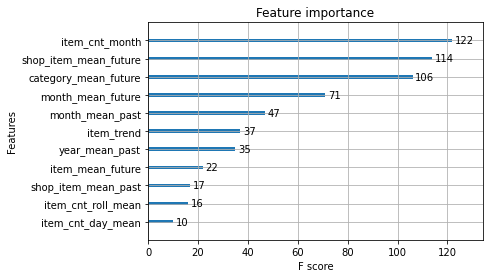

In [192]:
import matplotlib.pyplot as plt

plot_importance(model)
plt.show()

## 6. Tuning parameters and getting feature importance for the best model 

In [217]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [247]:
linear_pipeline = Pipeline(steps=[
                    ('Scaler', StandardScaler()),
                    ('Regressor', HuberRegressor(max_iter=300, epsilon=1.3))
                  ])

print('Training model...')

# To save time the gridsearch cv is commented out as I've already ran it before and inputted parameters above
'''
parameters = {
                'Regressor__tol': [0.0001, 0.0005]
                'Regressor__max_iter': [300, 400]
                'Regressor__epsilon': [1.3, 1.35]
             }
            
cv_linear = GridSearchCV(
                linear_pipeline, 
                param_grid = parameters, 
                n_jobs=-1, 
                cv=TimeSeriesSplit(n_splits=3), 
                scoring='neg_mean_absolute_error')

cv_linear.fit(X_train, Y_train)
'''
linear_pipeline.fit(X_train, Y_train)

Training model...


Pipeline(steps=[('Scaler', StandardScaler()),
                ('Regressor', HuberRegressor(epsilon=1.3, max_iter=300))])

In [238]:
#cv_linear.best_estimator_.get_params()

{'memory': None,
 'steps': [('Scaler', StandardScaler()),
  ('Regressor', HuberRegressor(epsilon=1.3, max_iter=300, tol=0.0001))],
 'verbose': False,
 'Scaler': StandardScaler(),
 'Regressor': HuberRegressor(epsilon=1.3, max_iter=300, tol=0.0001),
 'Scaler__copy': True,
 'Scaler__with_mean': True,
 'Scaler__with_std': True,
 'Regressor__alpha': 0.0001,
 'Regressor__epsilon': 1.3,
 'Regressor__fit_intercept': True,
 'Regressor__max_iter': 300,
 'Regressor__tol': 0.0001,
 'Regressor__warm_start': False}

In [254]:
print('Evaluating model...')
mae, mae_non_zero = evaluate_model(linear_pipeline, estimator_last_3_months, X_test, Y_test, extended_test_set)
print('MAE and MAE non-zero on test data are {} and {}'.format(mae, mae_non_zero) )

Evaluating model...
MAE and MAE non-zero on test data are 0.05770735356990167 and 1.917952422114599


In [250]:
import pickle
print('Saving model...')
file_pkl = open('models/forecast_linear_v5.pkl', 'wb')
pickle.dump(linear_pipeline, file_pkl)
file_pkl.close()

Saving model...


### Output feature importances 

## 7. Testing on unseen shops 

In [294]:
def test_on_shops(model, list_of_shop_ids=range(30,40), data=None):
    if data is not None:
        data_new = data
    else:
        data_new = preprocess_data('data/sales_train.csv', 'data/items.csv', use_shop_ids=list_of_shop_ids)
    
    print(data_new.describe())
    
    X_train_new, Y_train_new, X_test_new, Y_test_new, X_predict_new, extended_test_set, predict_extended_new = return_processed_data(data_new)
    
    print('Evaluating model...')
    
    # Compare with base estimator that returns last 3-month average of items sold
    estimator_last_3_months = base_estimator('last_three_months')
    
    mae, mae_base, error_better, cash_better, total_sales = evaluate_model(model, estimator_last_3_months, X_test_new, Y_test_new, extended_test_set)
    
    min_month = extended_test_set['month'].iloc[0]
    min_year = extended_test_set['year'].iloc[0]
    max_month = extended_test_set['month'].iloc[-1]
    max_year = extended_test_set['year'].iloc[-1]
    
    if error_better >= 0:
        result_word = 'YES'
    else:
        result_word = 'NO'
    
    print('Can you trust the given forecast? Probably {}.'.format(result_word))
    print('To answer that question we checked the forecast-genereating model on test period: from {}/{} to the end of {}/{}.'.format(min_month, min_year, max_month, max_year))
    print('Then, the model was compared to a simple estimator which forecasts items sold next month as the average of items sold last 3 months.')
    print('Mean average error for the model on test data is {} items.'.format(mae) )
    print('Mean average error for the simple estimator on test data is {} items.'.format(mae_base) )
    
    if error_better > 0:
        result_word = 'better'
    elif error_better == 0:
        result_word = ' different - meaning produced the same error'
    else:
        result_word = 'worse'
    
    print('In terms of the number of items sold, the model was {}% {} compared to the simple estimator.'.format(round(100*error_better,2), result_word))
    saving = int(total_sales*cash_better)
    if cash_better > 0:
        print('In terms of the money, the model could have helped to better allocate {} or {}% of total sales of {} during the test period.*'.format(saving, round(100*cash_better,2), total_sales))
        print('   *These figures are calculated by comparing model forecast with the simple estimator and could have been achivied by stocking items that customers would purchase and not stocking items that were not ultimately purchased.')

### Load the best model 

In [265]:
import joblib
print('Loading model...')
model_linear = joblib.load("models/forecast_best_linear.pkl")

Loading model...


### Testing on 10 shops 

In [293]:
test_on_shops(model_linear, range(30,40))

             shop_id        item_id     item_price   item_cnt_day  \
count  463064.000000  463064.000000  463064.000000  463064.000000   
mean       32.915817   10441.734393     844.710115       1.249123   
std         2.907901    6282.046974    1644.080120       1.802047   
min        30.000000      26.000000      -1.000000      -2.000000   
25%        31.000000    4808.000000     249.000000       1.000000   
50%        31.000000   10020.000000     399.000000       1.000000   
75%        35.000000   15843.000000     899.000000       1.000000   
max        39.000000   22167.000000   41990.000000     288.000000   

       item_category_id  
count     463064.000000  
mean          40.554848  
std           16.772232  
min            0.000000  
25%           30.000000  
50%           40.000000  
75%           55.000000  
max           83.000000  
Evaluating model...
Can you trust the given forecast? Probably YES.
To answer that question we checked the forecast-genereating model on test pe

### Testing on the shop from web app template 

In [291]:
data_42 = pd.read_excel('app/downloads/excel_template.xls')
test_on_shops(model_linear, data=data_42)

            item_id    item_price  item_cnt_day  item_category_id
count   9289.000000   9289.000000   9289.000000       9289.000000
mean    9701.012057   1211.644155      1.346001         38.419851
std     6353.900879   2205.336580      2.690541         18.415012
min       30.000000      0.500000     -1.000000          2.000000
25%     4231.000000    299.000000      1.000000         23.000000
50%     7808.000000    600.000000      1.000000         37.000000
75%    15438.000000   1399.000000      1.000000         55.000000
max    22167.000000  26499.000000    167.000000         83.000000
Evaluating model...
Can you trust the given forecast? Probably YES.
To answer that question we checked the forecast-genereating model on test period: from 9/2014 to the end of 10/2014.
Then, the model was compared to a simple estimator which forecasts items sold next month as the average of items sold last 3 months.
Mean average error for the model on test data is 0.8 items.
Mean average error for the s

## 8. Conclusions 